In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load_all_experiments(path="."):
    dfs = []
    pat = re.compile(r"experiment_(\w+)_yolov5([nsm])_(\d+)fps_\d{8}_\d{6}(?:_\d+)?\.csv$")
    for file in os.listdir(path):
        if not file.endswith(".csv"):
            continue
        m = pat.match(file)
        if not m:
            continue
        raw_mode, model, fps = m.groups()
        df = pd.read_csv(os.path.join(path, file))
        df["experiment_mode"] = "local" if raw_mode == "LocalOnly" else "offload"
        df["model"] = f"yolov5{model}"
        df["fps"] = int(fps)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

model_order = ["yolov5n", "yolov5s", "yolov5m"]
df_all = load_all_experiments(".")
df_all["latency_ms"] = df_all["total_latency_us"] / 1000.0
df_all["model"] = pd.Categorical(df_all["model"], categories=model_order, ordered=True)

In [2]:
summary = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)["latency_ms"]
          .agg(count="count", mean="mean", median="median", std="std", min="min", max="max")
          .reset_index()
          .sort_values(["fps", "model", "experiment_mode"])
)
display(summary)

comparison_table = (
    summary.pivot_table(
        index=["fps", "model"],
        columns="experiment_mode",
        values="mean",
        observed=True
    )
    .reset_index()
)
comparison_table.columns.name = None
comparison_table["model"] = pd.Categorical(comparison_table["model"], categories=model_order, ordered=True)
comparison_table = comparison_table.sort_values(by=["fps", "model"])
comparison_table["speedup"] = comparison_table["local"] / comparison_table["offload"]
comparison_table = comparison_table[["fps", "model", "local", "offload", "speedup"]].reset_index(drop=True)
display(comparison_table)

,fps,model,experiment_mode,count,mean,median,std,min,max
0,1,yolov5n,local,599,888.663633,888.0460,51.705789,806.886,1220.650
1,1,yolov5n,offload,600,387.010188,381.9435,51.333915,270.663,645.002
2,1,yolov5s,local,341,2308.998158,2311.2310,306.723543,1772.586,3596.481
3,1,yolov5s,offload,600,432.966393,429.5970,56.290413,242.684,744.084
4,1,yolov5m,local,155,4449.364452,4458.8120,305.170331,3871.374,5070.116
5,1,yolov5m,offload,600,563.297483,561.8115,59.690185,356.398,955.756
6,5,yolov5n,local,569,1006.017081,1009.1750,97.208913,819.577,1538.637
7,5,yolov5n,offload,2979,208.297496,205.3860,18.085366,184.977,536.825
8,5,yolov5s,local,346,1882.085384,1849.0000,140.559854,1681.806,3857.796
9,5,yolov5s,offload,2978,224.331341,220.0765,24.316851,206.952,542.921


,fps,model,local,offload,speedup
0,1,yolov5n,888.663633,387.010188,2.296228
1,1,yolov5s,2308.998158,432.966393,5.332973
2,1,yolov5m,4449.364452,563.297483,7.898783
3,5,yolov5n,1006.017081,208.297496,4.829713
4,5,yolov5s,1882.085384,224.331341,8.389757
5,5,yolov5m,4285.350156,534.610519,8.015836
6,10,yolov5n,899.229684,346.693699,2.593730
7,10,yolov5s,1846.182429,290.693811,6.350952
8,10,yolov5m,3977.746974,1133.547737,3.509113
9,15,yolov5n,912.254185,364.827758,2.500507


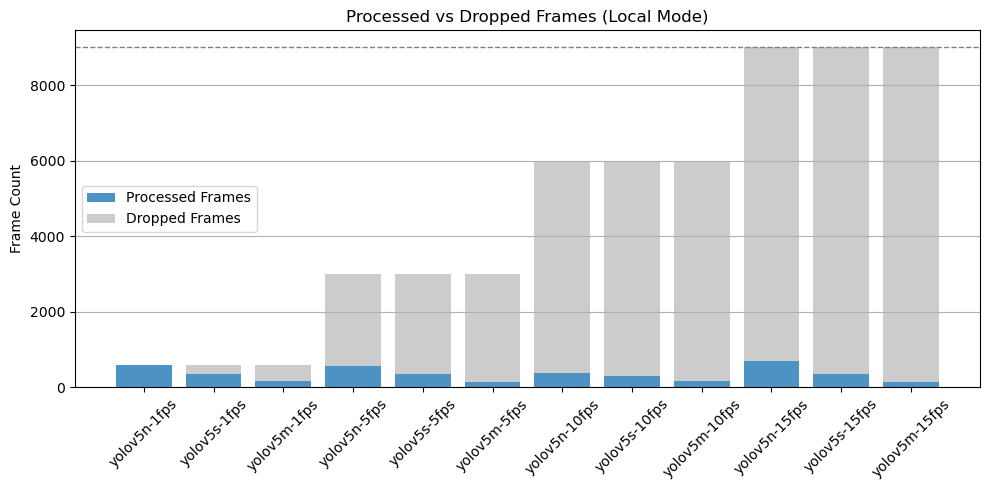

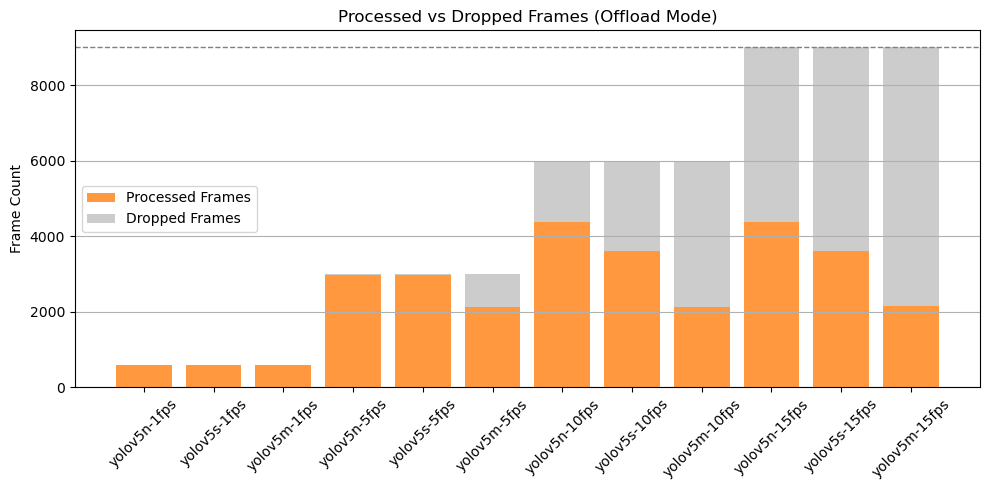

In [3]:
hue_order = ["local", "offload"]
palette = {"local": "#1f77b4", "offload": "#ff7f0e"}
experiment_duration_s = 600

frame_counts = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)
    .size()
    .reset_index(name="actual_frames")
)
frame_counts["expected_frames"] = frame_counts["fps"] * experiment_duration_s
frame_counts["dropped_frames"] = frame_counts["expected_frames"] - frame_counts["actual_frames"]
frame_counts["model"] = pd.Categorical(frame_counts["model"], categories=model_order, ordered=True)
frame_counts = frame_counts.sort_values(by=["fps", "model"])

for mode in hue_order:
    subset = frame_counts[frame_counts["experiment_mode"] == mode]
    labels = [f"{model}-{fps}fps" for model, fps in zip(subset["model"], subset["fps"])]
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, subset["actual_frames"], label="Processed Frames", color=palette[mode], alpha=0.8)
    plt.bar(labels, subset["dropped_frames"], bottom=subset["actual_frames"], label="Dropped Frames", color="gray", alpha=0.4)
    plt.axhline(y=experiment_duration_s * max(subset["fps"]), color='gray', linestyle='--', linewidth=1)
    plt.title(f"Processed vs Dropped Frames ({mode.capitalize()} Mode)")
    plt.ylabel("Frame Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis="y")
    plt.show()

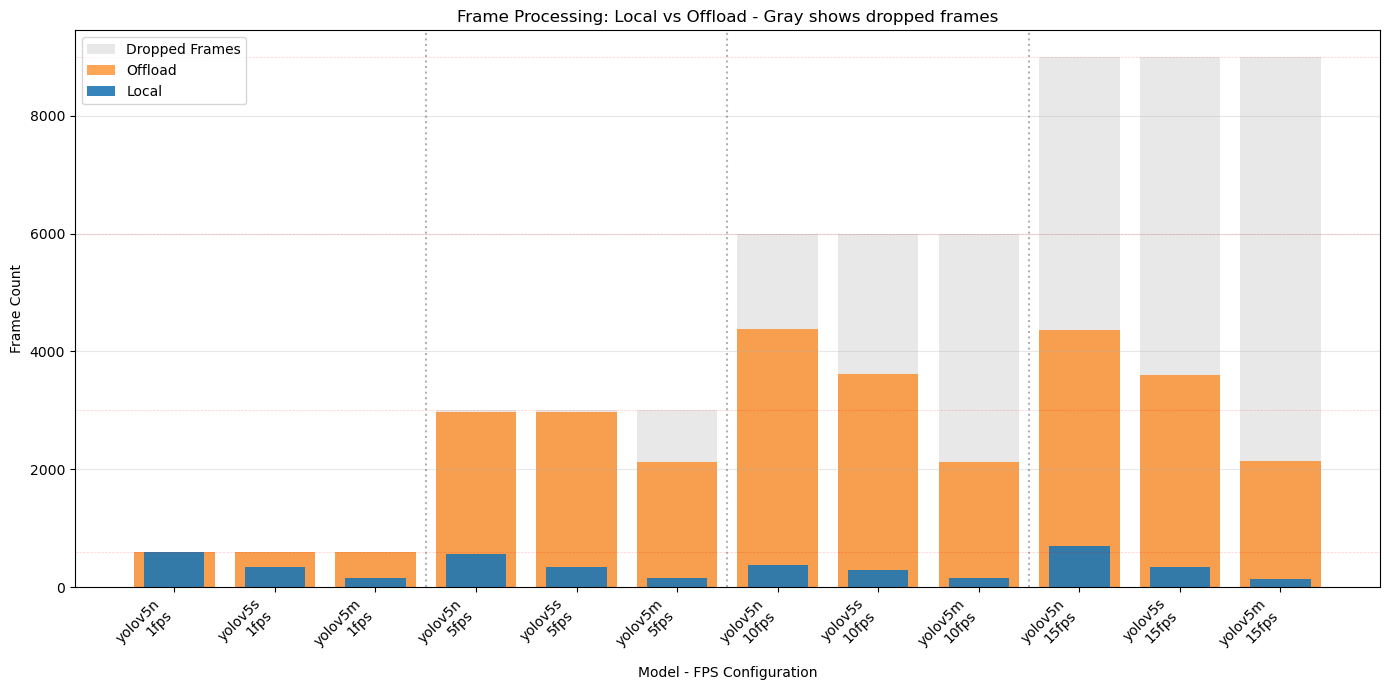

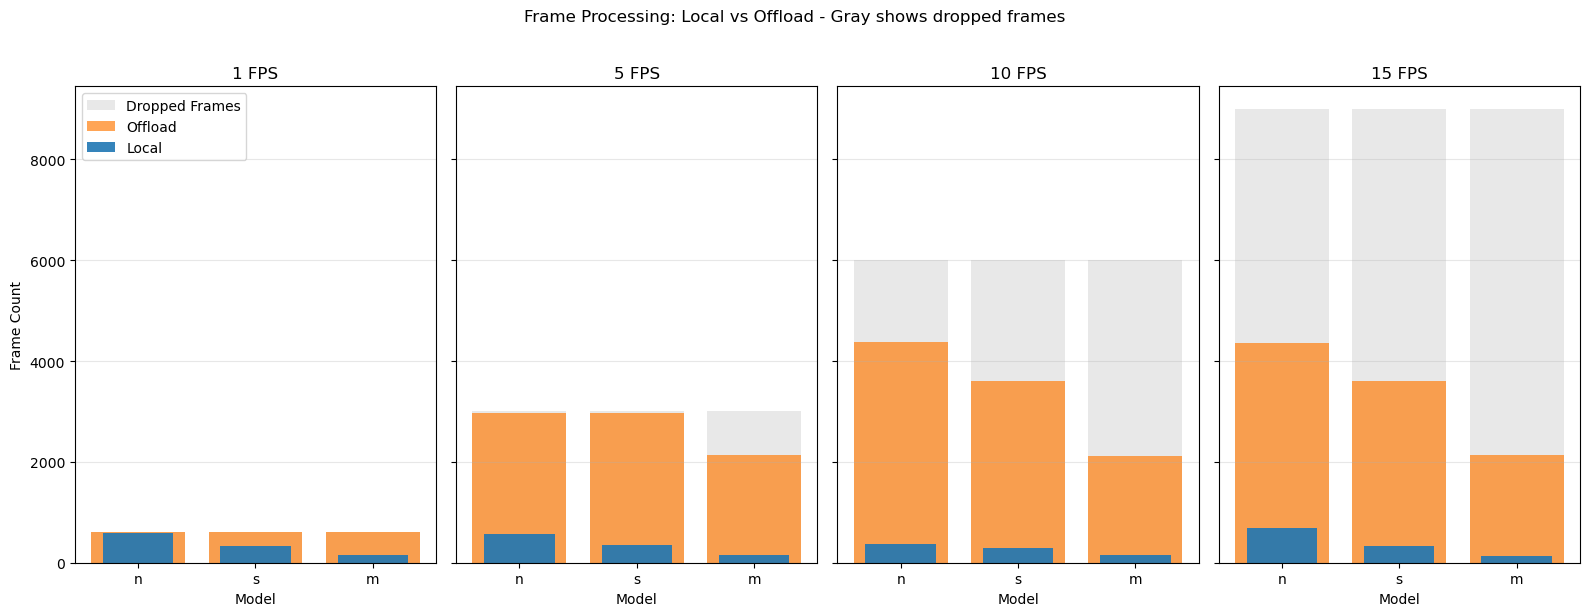

In [4]:
frame_counts = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)
    .size()
    .reset_index(name="actual_frames")
)
frame_counts["expected_frames"] = frame_counts["fps"] * experiment_duration_s
frame_counts["dropped_frames"] = frame_counts["expected_frames"] - frame_counts["actual_frames"]
frame_counts["model"] = pd.Categorical(frame_counts["model"], categories=model_order, ordered=True)
frame_counts = frame_counts.sort_values(by=["fps", "model"])

# Single overlaid bar chart
fig, ax = plt.subplots(figsize=(14, 7))

unique_combos = frame_counts[['model', 'fps']].drop_duplicates().sort_values(['fps', 'model'])
labels = [f"{model}\n{fps}fps" for model, fps in zip(unique_combos['model'], unique_combos['fps'])]
x = np.arange(len(labels))

for i, (model, fps) in enumerate(zip(unique_combos['model'], unique_combos['fps'])):
    local_data = frame_counts[(frame_counts['model'] == model) & 
                              (frame_counts['fps'] == fps) & 
                              (frame_counts['experiment_mode'] == 'local')]
    offload_data = frame_counts[(frame_counts['model'] == model) & 
                                (frame_counts['fps'] == fps) & 
                                (frame_counts['experiment_mode'] == 'offload')]
    
    expected = fps * experiment_duration_s
    
    ax.bar(i, expected, color='lightgray', alpha=0.5, width=0.8, 
           label='Dropped Frames' if i == 0 else "")
    
    if not offload_data.empty:
        offload_processed = offload_data['actual_frames'].values[0]
        ax.bar(i, offload_processed, color=palette["offload"], alpha=0.7, width=0.8,
               label='Offload' if i == 0 else "")
    
    if not local_data.empty:
        local_processed = local_data['actual_frames'].values[0]
        ax.bar(i, local_processed, color=palette["local"], alpha=0.9, width=0.6,
               label='Local' if i == 0 else "")

fps_changes = [i for i in range(1, len(unique_combos)) if unique_combos.iloc[i]['fps'] != unique_combos.iloc[i-1]['fps']]
for idx in fps_changes:
    ax.axvline(x=idx - 0.5, color='black', linestyle=':', alpha=0.3)

for fps_val in frame_counts['fps'].unique():
    ax.axhline(y=fps_val * experiment_duration_s, color='red', linestyle='--', alpha=0.2, linewidth=0.5)

ax.set_xlabel('Model - FPS Configuration')
ax.set_ylabel('Frame Count')
ax.set_title('Frame Processing: Local vs Offload - Gray shows dropped frames')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Subplots by FPS
fig, axes = plt.subplots(1, len(frame_counts['fps'].unique()), figsize=(16, 6), sharey=True)

for idx, fps_value in enumerate(sorted(frame_counts['fps'].unique())):
    ax = axes[idx]
    
    fps_subset = frame_counts[frame_counts['fps'] == fps_value]
    x = np.arange(len(model_order))
    
    for i, model in enumerate(model_order):
        local_data = fps_subset[(fps_subset['model'] == model) & 
                                (fps_subset['experiment_mode'] == 'local')]
        offload_data = fps_subset[(fps_subset['model'] == model) & 
                                  (fps_subset['experiment_mode'] == 'offload')]
        
        expected = fps_value * experiment_duration_s
        
        ax.bar(i, expected, color='lightgray', alpha=0.5, width=0.8,
               label='Dropped Frames' if i == 0 else "")
        
        if not offload_data.empty:
            offload_processed = offload_data['actual_frames'].values[0]
            ax.bar(i, offload_processed, color=palette["offload"], alpha=0.7, width=0.8,
                   label='Offload' if i == 0 else "")
        
        if not local_data.empty:
            local_processed = local_data['actual_frames'].values[0]
            ax.bar(i, local_processed, color=palette["local"], alpha=0.9, width=0.6,
                   label='Local' if i == 0 else "")
    
    ax.set_xlabel('Model')
    ax.set_title(f'{fps_value} FPS')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('yolov5', '') for m in model_order])
    ax.grid(axis='y', alpha=0.3)
    
    if idx == 0:
        ax.set_ylabel('Frame Count')
        ax.legend(loc='upper left')

plt.suptitle('Frame Processing: Local vs Offload - Gray shows dropped frames', y=1.02)
plt.tight_layout()
plt.show()

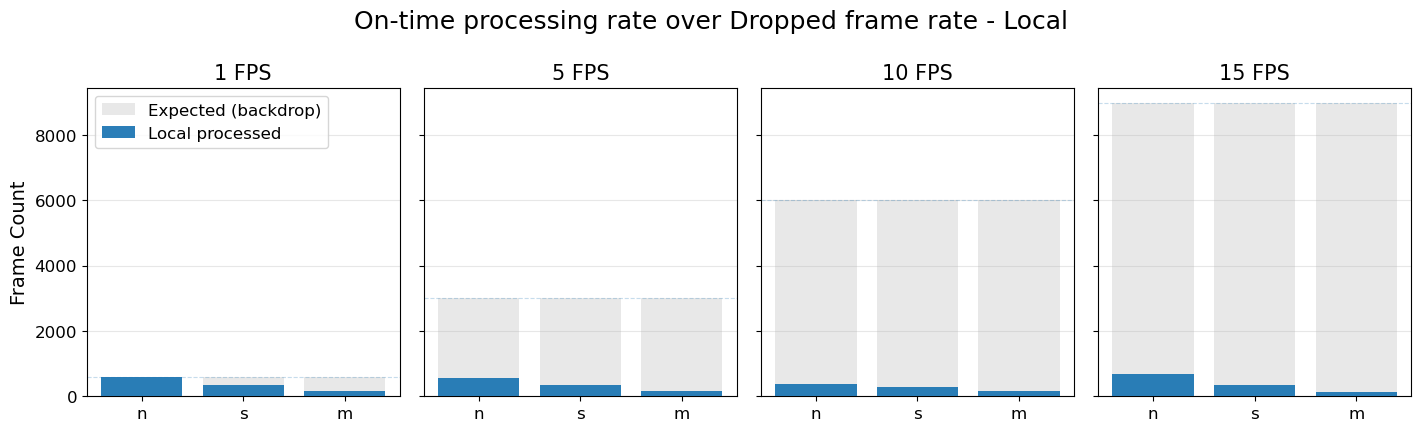

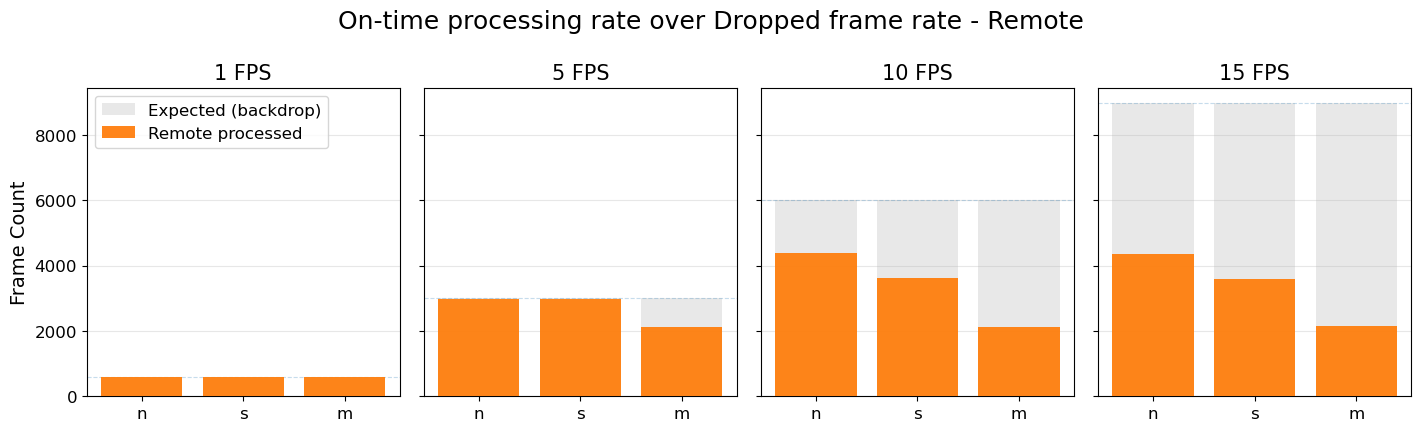

In [5]:
mode_labels = {"local": "Local", "offload": "Remote"}

plt.rcParams.update({
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 18
})

frame_counts = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)
    .size()
    .reset_index(name="actual_frames")
)
frame_counts["expected_frames"] = frame_counts["fps"] * experiment_duration_s
frame_counts["model"] = pd.Categorical(frame_counts["model"], categories=model_order, ordered=True)
fps_values = sorted(frame_counts["fps"].unique())

def plot_by_mode(fc, mode):
    data = fc[fc["experiment_mode"] == mode].copy()
    if data.empty:
        print(f"No rows for mode={mode}")
        return
        
    idx = pd.MultiIndex.from_product([fps_values, model_order], names=["fps", "model"])
    data = (data.set_index(["fps", "model"])
                .reindex(idx)
                .reset_index())
    data["expected_frames"] = data["fps"] * experiment_duration_s
    data["actual_frames"] = data["actual_frames"].fillna(0)
    
    n = len(fps_values)
    fig, axes = plt.subplots(1, n, figsize=(3.6 * n, 4.4), sharey=True)
    if n == 1:
        axes = [axes]
        
    for ax, fps in zip(axes, fps_values):
        sub = data[data["fps"] == fps].copy()
        sub["model"] = pd.Categorical(sub["model"], categories=model_order, ordered=True)
        sub = sub.sort_values("model")
        
        x = np.arange(len(model_order))
        
        ax.bar(
            x, sub["expected_frames"],
            width=0.8, color="lightgray", alpha=0.5,
            label="Expected (backdrop)" if fps == fps_values[0] else "",
            zorder=1
        )
        
        ax.bar(
            x, sub["actual_frames"],
            width=0.8, color=palette[mode], alpha=0.95,
            label=f"{mode_labels[mode]} processed" if fps == fps_values[0] else "",
            zorder=3, edgecolor="none"
        )
        
        ax.axhline(y=fps * experiment_duration_s, linestyle="--", linewidth=0.8, alpha=0.25, zorder=2)
        
        ax.set_title(f"{fps} FPS")
        ax.set_xticks(x)
        ax.set_xticklabels([m.replace("yolov5", "") for m in model_order])
        ax.grid(axis="y", alpha=0.3, zorder=0)
        
    axes[0].set_ylabel("Frame Count")
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(loc="upper left")
        
    fig.suptitle(f"On-time processing rate over Dropped frame rate - {mode_labels[mode]}")
    fig.tight_layout()
    plt.show()

plot_by_mode(frame_counts, mode="local")
plot_by_mode(frame_counts, mode="offload")

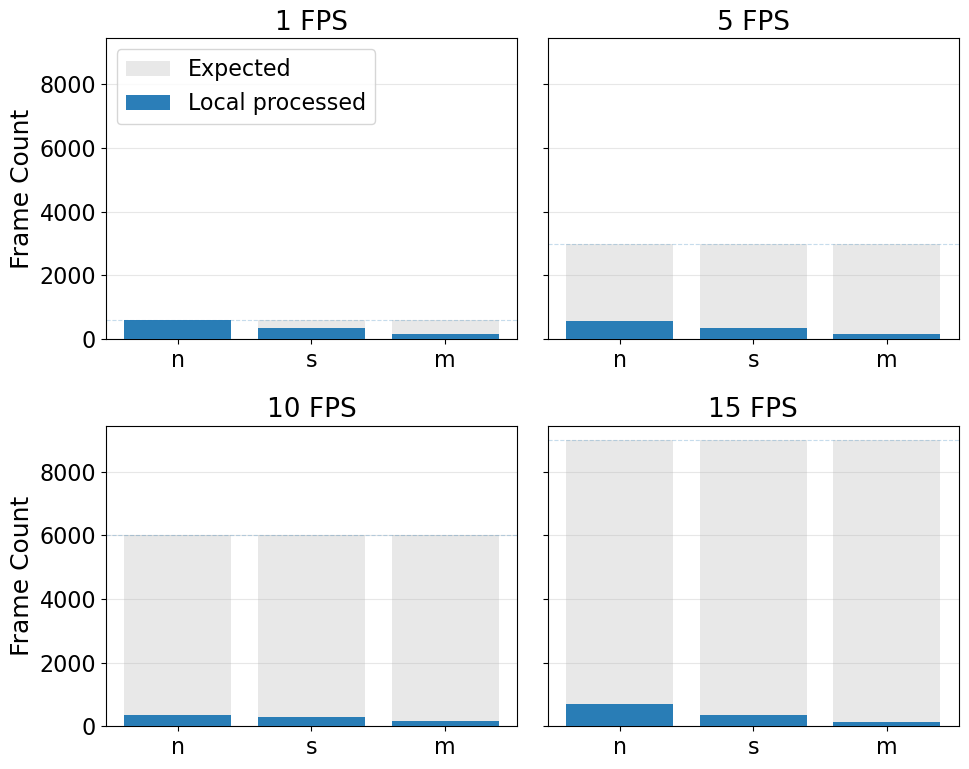

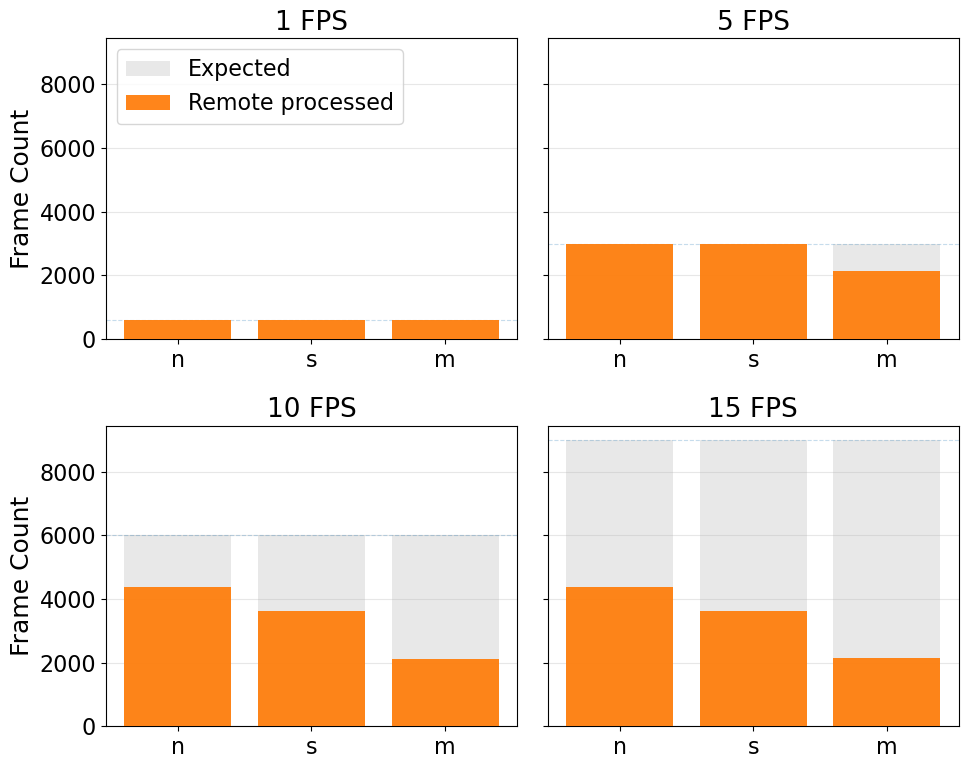

In [12]:
mode_labels = {"local": "Local", "offload": "Remote"}

plt.rcParams.update({
    "font.size": 17,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "figure.titlesize": 22
})

frame_counts = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)
    .size()
    .reset_index(name="actual_frames")
)
frame_counts["expected_frames"] = frame_counts["fps"] * experiment_duration_s
frame_counts["model"] = pd.Categorical(frame_counts["model"], categories=model_order, ordered=True)
fps_values = sorted(frame_counts["fps"].unique())

def plot_mode_grid(fc, mode):
    data = fc[fc["experiment_mode"] == mode].copy()
    if data.empty:
        print(f"No rows for mode={mode}")
        return
        
    idx = pd.MultiIndex.from_product([fps_values, model_order], names=["fps", "model"])
    data = (data.set_index(["fps", "model"])
                .reindex(idx)
                .reset_index())
    data["expected_frames"] = data["fps"] * experiment_duration_s
    data["actual_frames"] = data["actual_frames"].fillna(0)
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
    axes = axes.flatten()
    
    for fps_idx, fps in enumerate(fps_values):
        ax = axes[fps_idx]
        
        sub = data[data["fps"] == fps].copy()
        sub["model"] = pd.Categorical(sub["model"], categories=model_order, ordered=True)
        sub = sub.sort_values("model")
        
        x = np.arange(len(model_order))
        
        ax.bar(
            x, sub["expected_frames"],
            width=0.8, color="lightgray", alpha=0.5,
            label="Expected" if fps_idx == 0 else "",
            zorder=1
        )
        
        ax.bar(
            x, sub["actual_frames"],
            width=0.8, color=palette[mode], alpha=0.95,
            label=f"{mode_labels[mode]} processed" if fps_idx == 0 else "",
            zorder=3, edgecolor="none"
        )
        
        ax.axhline(y=fps * experiment_duration_s, linestyle="--", linewidth=0.8, alpha=0.25, zorder=2)
        
        ax.set_title(f"{fps} FPS")
        ax.set_xticks(x)
        ax.set_xticklabels([m.replace("yolov5", "") for m in model_order])
        ax.grid(axis="y", alpha=0.3, zorder=0)
        
        if fps_idx in [0, 2]:
            ax.set_ylabel("Frame Count")
    
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(loc="upper left")
        
    plt.tight_layout()
    plt.show()

plot_mode_grid(frame_counts, mode="local")
plot_mode_grid(frame_counts, mode="offload")

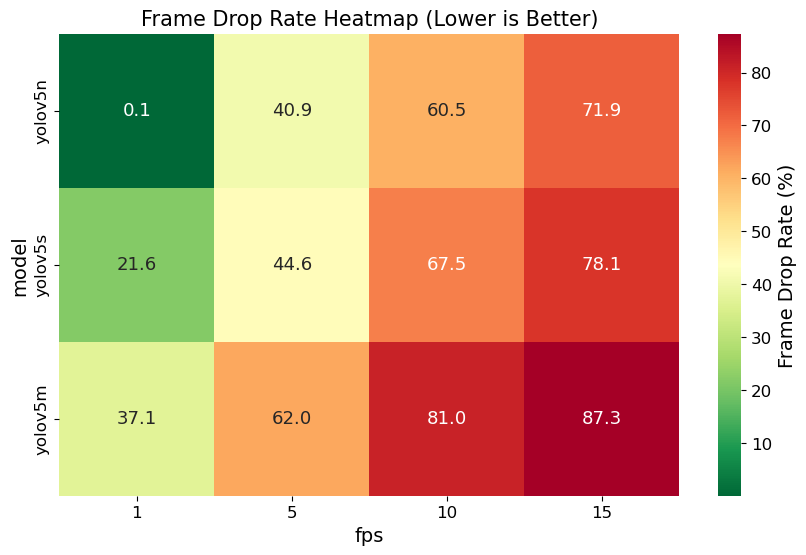

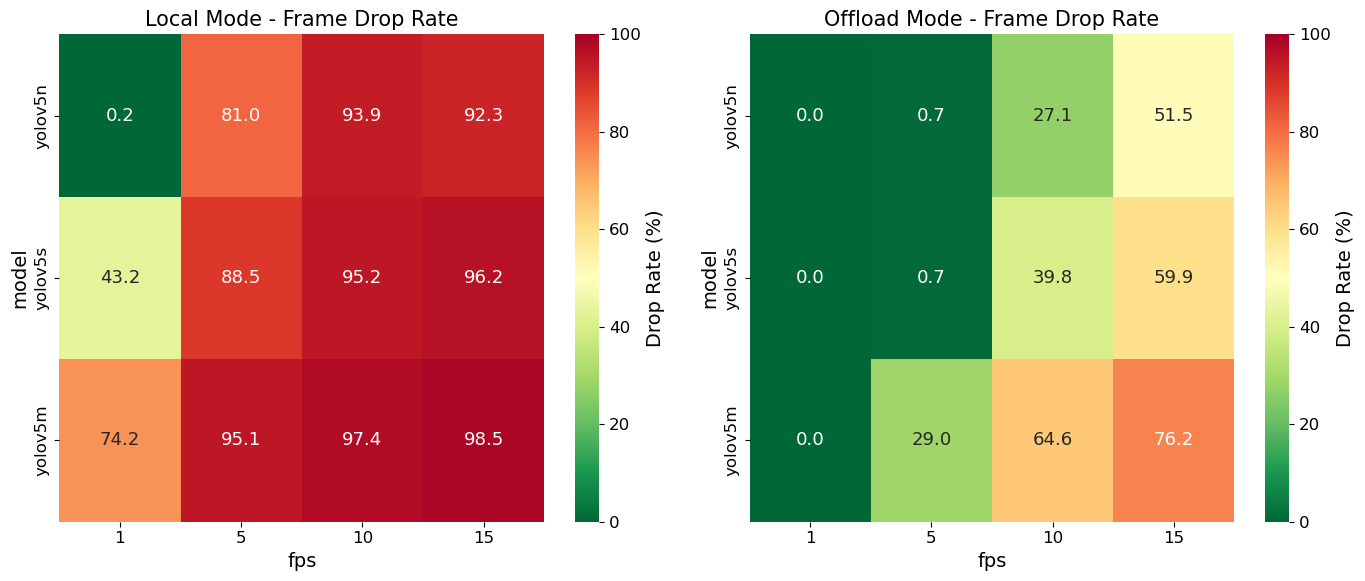

In [8]:
frame_counts = (
    df_all.groupby(["fps", "model", "experiment_mode"], observed=True)
    .size()
    .reset_index(name="actual_frames")
)
frame_counts["expected_frames"] = frame_counts["fps"] * experiment_duration_s
frame_counts["dropped_frames"] = frame_counts["expected_frames"] - frame_counts["actual_frames"]
frame_counts['drop_rate'] = (frame_counts['dropped_frames'] / frame_counts['expected_frames']) * 100
frame_counts['processing_rate'] = (frame_counts['actual_frames'] / frame_counts['expected_frames']) * 100

pivot_drop_rate = frame_counts.pivot_table(
    index='model', 
    columns='fps', 
    values='drop_rate', 
    aggfunc='mean',
    observed=True
)
pivot_drop_rate = pivot_drop_rate.reindex(model_order)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_drop_rate, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Frame Drop Rate (%)'})
plt.title('Frame Drop Rate Heatmap (Lower is Better)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, mode in enumerate(hue_order):
    subset = frame_counts[frame_counts['experiment_mode'] == mode]
    pivot = subset.pivot_table(index='model', columns='fps', values='drop_rate', observed=True)
    pivot = pivot.reindex(model_order)
    
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                ax=axes[idx], vmin=0, vmax=100,
                cbar_kws={'label': 'Drop Rate (%)'})
    axes[idx].set_title(f'{mode.capitalize()} Mode - Frame Drop Rate')
    
plt.tight_layout()
plt.show()